## Préambule

In [10]:
#Chargement de dépendances

import numpy as np
import matplotlib.pyplot as plt

#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta
#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

distmat=abs(np.subtract.outer(discretization,discretization))
Sigma=Covexp(distmat,a,sigma2)

SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]
SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))

invSigma = np.linalg.inv(SigmaObs) 
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))

Cholesky = np.linalg.cholesky(SigmaCond)

allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth

def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

# Projet Numérique de Probabilités

## Valeurs Positives

### Question 1

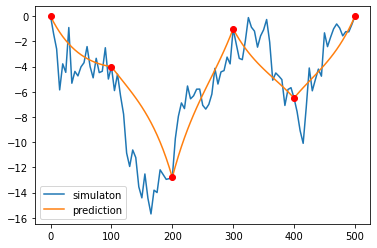

In [36]:
def simu_pos():
    while True:
        x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        simu = Ec + np.matmul(Cholesky,x)

        if any(x > 0 for x in simu):
            continue
        else:
            break
    return simu

simu = simu_pos()
        
allval3 = np.zeros(N)
allval3[unknown_indexes]=simu
allval3[observation_indexes]=depth
plt.plot(discretization,allval3, label='simulaton')
plt.plot(discretization,allval1, label='prediction')
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.legend();

### Question 2

La valeur moyenne de la longueur du câble est 521.72m, ce qui est quasiment le même résultat que pour la simulation où on 
permet des altitudes positives.
L'intervalle de confiance à 95% est [516.56,527.62]. Là aussi, on retrouve des résultats très similaires à la simulation 
précédente.
Enfin, la probabilité que la longueur du câble dépasse 525m est 0.123, ce qui est plus faible que pour la simulation 
précédente.


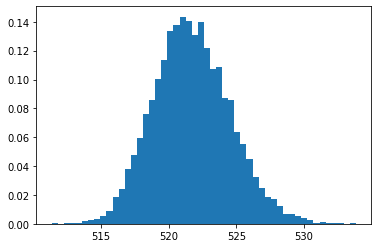

Le taux de rejet de l'algorithme choisi est 0.964. C'est très élevé, ce qui explique que ce bloc de code soit relativement long à faire tourner.


In [42]:
K = 10000
result = np.zeros(K)
for i in range(K):
    x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    allval3[unknown_indexes] = simu_pos()
    result[i]=length(allval3,Delta)

quantiles = np.quantile(result,[0.025,0.975])
    
print(f"""La valeur moyenne de la longueur du câble est {sum(result)/K:.2f}m, ce qui est quasiment le même résultat que pour la simulation où on 
permet des altitudes positives.\nL'intervalle de confiance à 95% est [{quantiles[0]:.2f},{quantiles[1]:.2f}]. Là aussi, on retrouve des résultats très similaires à la simulation 
précédente.\nEnfin, la probabilité que la longueur du câble dépasse 525m est {np.mean(result>525):.3f}, ce qui est plus faible que pour la simulation 
précédente.""")

plt.hist(result,50,density=True)
plt.show();

rejet = 0
for i in range(K):
    x = x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    simu = Ec + np.matmul(Cholesky,x)
    if any(x > 0 for x in simu):
        rejet += 1
        
print(f"Le taux de rejet de l'algorithme choisi est {rejet / K:.3f}. C'est très élevé, ce qui explique que ce bloc de code soit relativement long à faire tourner.")

## Approche Bayésienne

### Question 3